In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.signal import find_peaks

from sre_parse import CATEGORIES

all = pd.DataFrame(pd.read_excel('complete_data_left_right_anomalie_mech.xlsx'))


all.dropna()
all.shape

data = all[['acc.ax','acc.ay','acc.az','acc.gx','acc.gy','acc.gz','gyro.gx','gyro.gy','gyro.gz','timestamp']]
target = all[['target']]
target_names = all[['target.names']]
print(all.head())

     acc.ax    acc.ay    acc.az  acc.gx  acc.gy  acc.gz   gyro.gx   gyro.gy  \
0 -0.033672 -0.069784  1.158024   -5.04   -5.39   24.92 -0.208696 -4.730435   
1 -0.045384  0.149816  1.056032   -1.12    0.35   25.06 -0.069565 -2.365217   
2  0.022936  0.010736  0.818864    4.69   -3.36   26.39  1.043478  5.773913   
3 -0.072712  0.190808  1.031632   -2.66   -5.88   27.09 -2.226087  0.695652   
4 -0.027328  0.109312  1.126304    1.54   -5.74   29.19  2.295652  6.191304   

    gyro.gz      timestamp  target target.names    a  
0  26.78261  1662114927655       1    left_with  NaN  
1  28.52174  1662114927713       1    left_with  NaN  
2  27.13043  1662114927771       1    left_with  NaN  
3  28.59130  1662114927830       1    left_with  NaN  
4  27.96522  1662114927918       1    left_with  NaN  


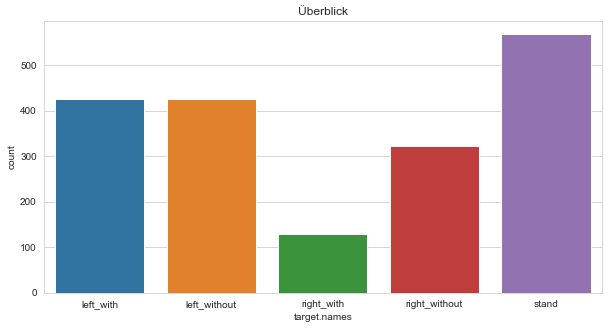

In [2]:
sns.set_style('whitegrid') 
plt.figure(figsize = (10, 5)) 
sns.countplot(x = 'target.names', data = all) 
plt.title('Überblick') 
plt.show( )

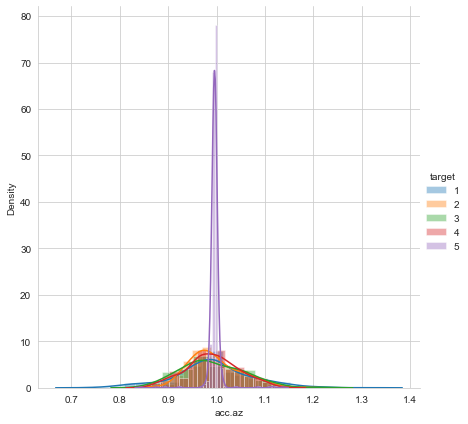

In [3]:
sns.FacetGrid(all, hue = 'target', size = 6).map(sns.distplot, 'acc.az').add_legend()

In [4]:
accgz_list = []

accaz_list = []
gyrogz_list = []
train_labels = []



step_size = 5

# creating overlaping windows of size window-size 100
for i in range(0, data.shape[0], step_size):
    accaz = data['acc.az'].values[i: i + 50]
    accgz = data['acc.gz'].values[i: i + 50]
    gyrogz = data['gyro.gz'].values[i: i + 50]
    label = stats.mode(target[i: i + 50])[0][0]

    print(label)
    accaz_list.append(accaz)
    accgz_list.append(accgz)
    gyrogz_list.append(gyrogz)
    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_data = pd.DataFrame()

# Mittelwert
X_data['accaz_mean'] = pd.Series(accaz_list).apply(lambda x: x.mean())
X_data['accgz_mean'] = pd.Series(accgz_list).apply(lambda x: x.mean())
X_data['gyrogz_mean'] = pd.Series(gyrogz_list).apply(lambda x: x.mean())

# Standardabweichung
X_data['accaz_std'] = pd.Series(accaz_list).apply(lambda x: x.std())
X_data['accgz_std'] = pd.Series(accgz_list).apply(lambda x: x.std())
X_data['gyrogz_std'] = pd.Series(gyrogz_list).apply(lambda x: x.std())

# durchschnittliche absolute Abweichung
X_data['accaz_aad'] = pd.Series(accaz_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_data['accgz_aad'] = pd.Series(accgz_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_data['gyrogz_aad'] = pd.Series(gyrogz_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# Minimalwert
X_data['accaz_min'] = pd.Series(accaz_list).apply(lambda x: x.min())
X_data['accgz_min'] = pd.Series(accgz_list).apply(lambda x: x.min())
X_data['gyrogz_min'] = pd.Series(gyrogz_list).apply(lambda x: x.min())

# Maximalwert
X_data['accaz_max'] = pd.Series(accaz_list).apply(lambda x: x.max())
X_data['accgz_max'] = pd.Series(accgz_list).apply(lambda x: x.max())
X_data['gyrogz_max'] = pd.Series(gyrogz_list).apply(lambda x: x.max())

# Differenz von Maximal- und Minimalwert
X_data['accaz_maxmin_diff'] = X_data['accaz_max'] - X_data['accaz_min']
X_data['accgz_maxmin_diff'] = X_data['accgz_max'] - X_data['accgz_min']
X_data['gyrogz_maxmin_diff'] = X_data['gyrogz_max'] - X_data['gyrogz_min']

# Median
X_data['accaz_median'] = pd.Series(accaz_list).apply(lambda x: np.median(x))
X_data['accgz_median'] = pd.Series(accgz_list).apply(lambda x: np.median(x))
X_data['gyrogz_median'] = pd.Series(gyrogz_list).apply(lambda x: np.median(x))

# Median absolute Abweichung
X_data['accaz_mad'] = pd.Series(accaz_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_data['accgz_mad'] = pd.Series(accgz_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_data['gyrogz_mad'] = pd.Series(gyrogz_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# Interquartilbereich
X_data['accaz_IQR'] = pd.Series(accaz_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_data['accgz_IQR'] = pd.Series(accgz_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_data['gyrogz_IQR'] = pd.Series(gyrogz_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# Negative Werte zählen
X_data['accaz_neg_count'] = pd.Series(accaz_list).apply(lambda x: np.sum(x < 0))
X_data['accgz_neg_count'] = pd.Series(accgz_list).apply(lambda x: np.sum(x < 0))
X_data['gyrogz_neg_count'] = pd.Series(gyrogz_list).apply(lambda x: np.sum(x < 0))

# Positive Werte zählen
X_data['accaz_pos_count'] = pd.Series(accaz_list).apply(lambda x: np.sum(x > 0))
X_data['accgz_pos_count'] = pd.Series(accgz_list).apply(lambda x: np.sum(x > 0))
X_data['gyrogz_pos_count'] = pd.Series(gyrogz_list).apply(lambda x: np.sum(x > 0))

# Anzahl der Werte über dem Mittelwert
X_data['accaz_above_mean'] = pd.Series(accaz_list).apply(lambda x: np.sum(x > x.mean()))
X_data['accgz_above_mean'] = pd.Series(accgz_list).apply(lambda x: np.sum(x > x.mean()))
X_data['gyrogz_above_mean'] = pd.Series(gyrogz_list).apply(lambda x: np.sum(x > x.mean()))

# Anzahl der Spitzen
X_data['accaz_peak_count'] = pd.Series(accaz_list).apply(lambda x: len(find_peaks(x)[0]))
X_data['accgz_peak_count'] = pd.Series(accgz_list).apply(lambda x: len(find_peaks(x)[0]))
X_data['gyrogz_peak_count'] = pd.Series(gyrogz_list).apply(lambda x: len(find_peaks(x)[0]))

# energy
X_data['accaz_energy'] = pd.Series(accaz_list).apply(lambda x: np.sum(x**2)/100)
X_data['accgz_energy'] = pd.Series(accgz_list).apply(lambda x: np.sum(x**2)/100)
X_data['gyrogz_energy'] = pd.Series(gyrogz_list).apply(lambda x: np.sum(x**2)/100)

# skewness
#X_data['accaz_skewness'] = pd.Series(accagyrogz_list).apply(lambda x: stats.skew(x))
#X_data['accgz_skewness'] = pd.Series(accggyrogz_list).apply(lambda x: stats.skew(x))
#X_data['gyrogz_skewness'] = pd.Series(gyrogz_list).apply(lambda x: stats.skew(x))

# kurtosis
#X_data['accaz_kurtosis'] = pd.Series(accagyrogz_list).apply(lambda x: stats.kurtosis(x))
#X_data['accgz_kurtosis'] = pd.Series(accggyrogz_list).apply(lambda x: stats.kurtosis(x))
#X_data['gyrogz_kurtosis'] = pd.Series(gyrogz_list).apply(lambda x: stats.kurtosis(x))


#avg resultant
X_data['avg_result_accl'] = [i.mean() for i in ((pd.Series(accagyrogz_list)**2 + pd.Series(accggyrogz_list)**2 + pd.Series(gyrogz_list)**2)**0.5)]

#signal magnitude area
X_data['sma'] =  pd.Series(accagyrogz_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(accggyrogz_list).apply(lambda x: np.sum(abs(x)/100)) \
                 + pd.Series(gyrogz_list).apply(lambda x: np.sum(abs(x)/100))

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


NameError: name 'accagyrogz_list' is not defined

In [ ]:
print(X_data)

     accaz_mean  accgz_mean  gyrogz_mean  accaz_std  accgz_std  gyrogz_std  \
0      0.990611   26.646200    28.713739   0.113251   1.457857    1.511507   
1      0.988747   26.745600    28.762435   0.108216   1.443076    1.513597   
2      0.988561   26.896800    28.916870   0.098307   1.314850    1.507011   
3      0.984169   26.983600    29.032348   0.093787   1.280693    1.619876   
4      0.987751   26.961200    29.081044   0.092861   1.142383    1.721677   
..          ...         ...          ...        ...        ...         ...   
346    0.997077   -1.933333    -0.424016   0.063130   0.940508    0.799792   
347    0.997045   -1.828750    -0.491304   0.072053   1.055781    0.901825   
348    1.007764   -1.673636    -0.436364   0.080408   0.962320    1.006825   
349    0.991941   -1.505000    -0.614493   0.075135   1.096232    1.112621   
350    1.084824   -2.800000    -1.113043   0.000000   0.000000    0.000000   

     accaz_aad  accgz_aad  gyrogz_aad  accaz_min  ...  gyrogz_p

In [ ]:
X = X_data
y = train_labels


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)


from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=150, random_state=42)

logreg.fit(X_train,y_train)

##print(X_data2)
##print(y_train)

y_pred = logreg.predict(X_test)


print(y_pred)

from sklearn import metrics

#print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test,y_pred))



[3 5 5 5 3 5 5 3 5 4 2 2 4 2 4 1 5 2 2 2 5 1 4 5 2 1 5 1 2 4 5 4 1 2 5 2 1
 1 4 5 2 2 5 1 5 3 2 5 2 5 5 1 2 2 5 5 1 4 2 2 4 1 2 5 2 2 4 4 4 5 3 2 2 1
 2 5 1 2 4 5 5 2 3 2 5 2 5 5 5 4 5 1 2 1 5 5 4 5 5 4 2 5 5 5 1 2]
              precision    recall  f1-score   support

           1       1.00      0.89      0.94        18
           2       0.94      1.00      0.97        29
           3       0.67      1.00      0.80         4
           4       1.00      0.89      0.94        18
           5       1.00      1.00      1.00        37

    accuracy                           0.96       106
   macro avg       0.92      0.96      0.93       106
weighted avg       0.97      0.96      0.96       106



In [ ]:
from sklearn.ensemble import RandomForestClassifier



reg_rf = RandomForestClassifier()
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.89      0.94        18
           2       0.94      1.00      0.97        29
           3       0.67      1.00      0.80         4
           4       1.00      0.89      0.94        18
           5       1.00      1.00      1.00        37

    accuracy                           0.96       106
   macro avg       0.92      0.96      0.93       106
weighted avg       0.97      0.96      0.96       106



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

reg_knn = KNeighborsClassifier()
reg_knn.fit(X_train, y_train)
y_pred = reg_knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.89      0.94        18
           2       0.93      0.93      0.93        29
           3       0.50      1.00      0.67         4
           4       1.00      0.89      0.94        18
           5       1.00      1.00      1.00        37

    accuracy                           0.94       106
   macro avg       0.89      0.94      0.90       106
weighted avg       0.96      0.94      0.95       106



In [ ]:
feature_df = pd.DataFrame({'Importance':reg_rf.feature_importances_, 'Features': X_data.columns })
print(feature_df)

    Importance            Features
0     0.000105          accaz_mean
1     0.066180          accgz_mean
2     0.061039         gyrogz_mean
3     0.012104           accaz_std
4     0.016534           accgz_std
5     0.013937          gyrogz_std
6     0.010576           accaz_aad
7     0.015348           accgz_aad
8     0.016254          gyrogz_aad
9     0.008116           accaz_min
10    0.016919           accgz_min
11    0.029036          gyrogz_min
12    0.004351           accaz_max
13    0.011006           accgz_max
14    0.017287          gyrogz_max
15    0.004846   accaz_maxmin_diff
16    0.011815   accgz_maxmin_diff
17    0.035600  gyrogz_maxmin_diff
18    0.003032        accaz_median
19    0.064954        accgz_median
20    0.111200       gyrogz_median
21    0.022831           accaz_mad
22    0.031215           accgz_mad
23    0.049394          gyrogz_mad
24    0.019616           accaz_IQR
25    0.040805           accgz_IQR
26    0.038476          gyrogz_IQR
27    0.000000     a

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_data_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(max_iter =150, random_state = 0)
lr.fit(X_data_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9716981132075472

 -------------Classification Report-------------

              precision    recall  f1-score   support

           1       1.00      0.83      0.91        18
           2       0.91      1.00      0.95        29
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        37

    accuracy                           0.97       106
   macro avg       0.98      0.97      0.97       106
weighted avg       0.97      0.97      0.97       106

